In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santoshkumarguntupalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-04-19 21:13:12.613061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745093592.638026  204108 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745093592.645424  204108 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745093592.665338  204108 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745093592.665369  204108 computation_placer.cc:177] computation placer already registered. 

In [5]:
dataset = load_dataset("odegiber/hate_speech18", trust_remote_code=True)

data.zip:   0%|          | 0.00/3.19M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10944 [00:00<?, ? examples/s]

In [12]:
# Check the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 10944
    })
})


In [10]:
df = dataset['train'].to_pandas()

In [18]:
df.head()

,text,user_id,subforum_id,num_contexts,label
0,"As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .",572066,1346,0,0
1,"In order to help increase the booklets downloads , it would be great if all Stormfronters who had YouTube accounts , could display the following text in the description boxes of their uploaded YouTube videos .",572066,1346,0,0
2,( Simply copy and paste the following text into your YouTube videos description boxes. ),572066,1346,0,0
3,Click below for a FREE download of a colorfully illustrated 132 page e-book on the Zionist-engineered INTENTIONAL destruction of Western civilization .,572066,1346,0,1
4,Click on the `` DOWNLOAD ( 7.42 MB ) '' green banner link .,572066,1346,0,0


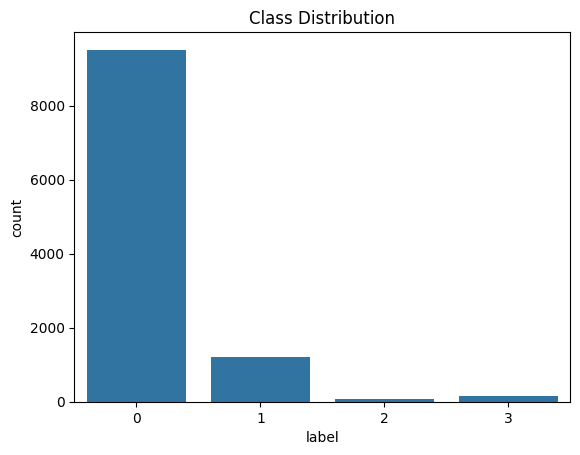

label
0    9507
1    1196
3     168
2      73
Name: count, dtype: int64


In [19]:
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

# Or value counts
print(df['label'].value_counts())


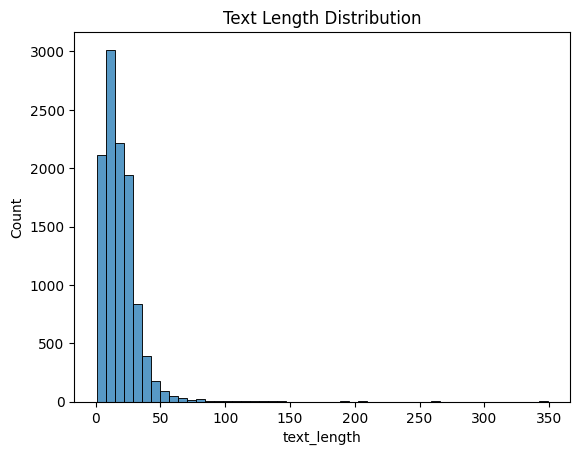

In [22]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.show()


In [26]:
print(df.isnull().sum())


text            0
user_id         0
subforum_id     0
num_contexts    0
label           0
text_length     0
dtype: int64


In [28]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

57


In [29]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)


In [31]:
df.head()

,text,user_id,subforum_id,num_contexts,label,text_length,clean_text
0,"As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .",572066,1346,0,0,18,as of march th the booklet had been downloaded over times and counting
1,"In order to help increase the booklets downloads , it would be great if all Stormfronters who had YouTube accounts , could display the following text in the description boxes of their uploaded YouTube videos .",572066,1346,0,0,36,in order to help increase the booklets downloads it would be great if all stormfronters who had youtube accounts could display the following text in the description boxes of their uploaded youtube videos
2,( Simply copy and paste the following text into your YouTube videos description boxes. ),572066,1346,0,0,15,simply copy and paste the following text into your youtube videos description boxes
3,Click below for a FREE download of a colorfully illustrated 132 page e-book on the Zionist-engineered INTENTIONAL destruction of Western civilization .,572066,1346,0,1,22,click below for a free download of a colorfully illustrated page ebook on the zionistengineered intentional destruction of western civilization
4,Click on the `` DOWNLOAD ( 7.42 MB ) '' green banner link .,572066,1346,0,0,14,click on the download mb green banner link


In [32]:
max_num_words = 10000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=max_sequence_length)


In [33]:
X

array([[   0,    0,    0, ...,  186,    4, 3802],
       [   0,    0,    0, ..., 3804,   53,  435],
       [   0,    0,    0, ...,  435, 2126, 3803],
       ...,
       [   0,    0,    0, ...,  505, 4759,   32],
       [   0,    0,    0, ...,   23,  108,   46],
       [   0,    0,    0, ...,    3,   51,    9]], dtype=int32)

In [35]:
label_mapping = {0: 'noHate', 1: 'hate', 2: 'relation', 3: 'idk/skip'}
df['label_num'] = df['label']
y = df['label_num']


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [39]:
model = Sequential([
    Embedding(input_dim=max_num_words, output_dim=128, input_length=max_sequence_length),
    LSTM(64),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=32
)


/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-19 21:46:10.784555: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.8460 - loss: 0.6034 - val_accuracy: 0.8794 - val_loss: 0.3775
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.8795 - loss: 0.3682 - val_accuracy: 0.8806 - val_loss: 0.3426
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9325 - loss: 0.2317 - val_accuracy: 0.8944 - val_loss: 0.3818
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9588 - loss: 0.1474 - val_accuracy: 0.8840 - val_loss: 0.4014
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.9729 - loss: 0.0923 - val_accuracy: 0.8898 - val_loss: 0.4915


In [40]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8655 - loss: 0.6080
Test Loss: 0.5991511940956116
Test Accuracy: 0.8654729127883911


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

print(classification_report(y_test, y_pred_classes))


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
[[1819   56    3   15]
 [ 176   60    0    3]
 [   8    0    3    1]
 [  28    3    0    3]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1893
           1       0.50      0.25      0.34       239
           2       0.50      0.25      0.33        12
           3       0.14      0.09      0.11        34

    accuracy                           0.87      2178
   macro avg       0.51      0.39      0.43      2178
weighted avg       0.84      0.87      0.85      2178



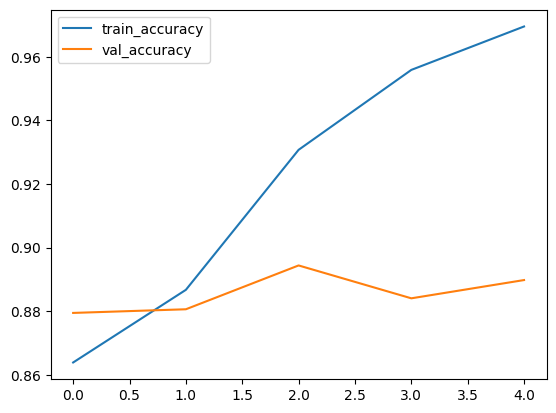

In [43]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
